In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from category_encoders import TargetEncoder
import sklearn
import zipfile
import warnings
from sklearn.exceptions import ConvergenceWarning

In [8]:
warnings.simplefilter('ignore', ConvergenceWarning)

# Unzip data

In [9]:
with zipfile.ZipFile('housedata.zip', 'r') as z:
    z.extractall('./')

In [10]:
data = pd.read_csv('data.csv')
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


# 2.1 
Determine which features are continuous vs categorical. Drop rows without a valid sales
price.

In [11]:
# Drop the date column and all rows with prices <= 0
data = data[data.price > 0.0]
data = data.drop(columns='date')
# Get the target 'price' column and remove it from the dataframe
# Remove 'street' and 'country'columns are not useful
price = data['price']
data = data.drop(columns=['price', 'country', 'street'])

In [227]:
data['has_basement'] = 0
data['has_lot'] = 0
data.loc[data['sqft_basement'] > 0, 'has_basement'] = 1
data.loc[data['sqft_lot'] > 0, 'has_lot'] = 1

In [ ]:
# Make column about log transforming prices
# Looked for all NaN values

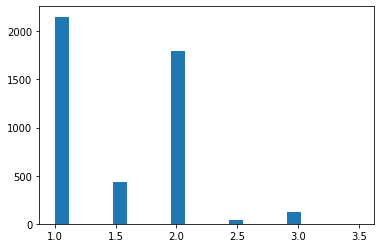

In [6]:
plt.hist(data['floors'], bins='auto')
plt.show()

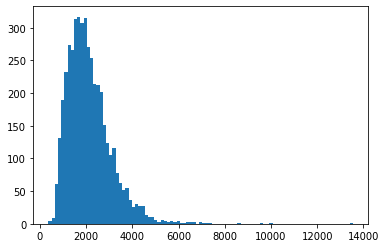

In [7]:
plt.hist(data['sqft_living'], bins='auto')
plt.show()

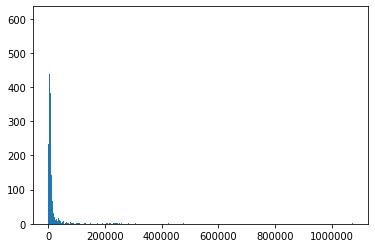

In [123]:
plt.hist(data['sqft_lot'], bins='auto')
plt.show()

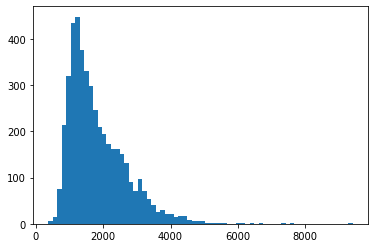

In [122]:
plt.hist(data['sqft_above'], bins='auto')
plt.show()

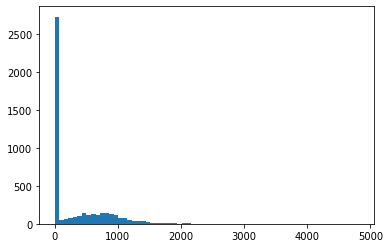

In [10]:
plt.hist(data['sqft_basement'], bins='auto')
plt.show()

In [12]:
for col in data.columns:
    print(col, data[col].dtypes)
print(len(data.columns))

bedrooms float64
bathrooms float64
sqft_living int64
sqft_lot int64
floors float64
waterfront int64
view int64
condition int64
sqft_above int64
sqft_basement int64
yr_built int64
yr_renovated int64
city object
statezip object
14


Within the dataset, the features which are continuous include bedrooms, bathrooms, sqft_living, sqft_loft, sqft_above, sqft_basement, The features which are categorial include the city, street, country, and statezip. As street and country are not useful for the task of predicting price, these columns have been dropped from the dataframe.

## 2.3 
Visualize the dependency of the target on each continuous feature (2d scatter plot).

In [228]:
# Separate features based on the type of preprocessing required
area = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 
             'bedrooms', 'bathrooms', 'floors']
categorical = ['waterfront', 'city', 'condition', 'view', 'has_basement', 'has_lot']
target = ['statezip']
year = ['yr_built', 'yr_renovated']

## 2.4
Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing
values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet
using cross-validation with the default parameters. Does scaling the data (within the pipeline)
with StandardScaler help? Use the preprocessing that works best going forward.

In [264]:
X_train, X_test, y_train, y_test = train_test_split(data, price, shuffle=True, random_state=10)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=5)

In [265]:
# Years have NA
yr_processing = Pipeline([('impute', SimpleImputer(strategy='most_frequent', missing_values=0))])
cat_processing = Pipeline([('impute', SimpleImputer(strategy='most_frequent', missing_values=0)),
                           ('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))])
target_processing = Pipeline([('encode', TargetEncoder())])

preprocess = make_column_transformer((yr_processing, year),
                                     (cat_processing, categorical),
                                     (target_processing, target),
                                     remainder='passthrough')

In [266]:
lin_reg_pipe = make_pipeline(preprocess, LinearRegression(fit_intercept=False))
lin_reg = cross_val_score(lin_reg_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lin_reg)

0.6566242707655326

In [267]:
ridge_pipe = make_pipeline(preprocess, Ridge(max_iter=1000))
ridge = cross_val_score(ridge_pipe, X_train, y_train, cv=cv_strategy)
np.mean(ridge)

0.5987730896302008

In [268]:
lasso_pipe = make_pipeline(preprocess, Lasso(max_iter=1000))
lasso = cross_val_score(lasso_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lasso)

0.6521108648509565

In [269]:
en_pipe = make_pipeline(preprocess, ElasticNet(max_iter=1000))
en = cross_val_score(en_pipe, X_train, y_train, cv=cv_strategy)
np.mean(en)

0.6372402371687255

Add scaling on continuous data

In [270]:
cont_processing = Pipeline([('scale', preprocessing.StandardScaler())])
preprocess_with_ss = make_column_transformer((yr_processing, year),
                                     (cont_processing, continuous),
                                     (cat_processing, categorical),
                                     (target_processing, target),
                                     remainder='passthrough')

In [271]:
lin_reg_pipe = make_pipeline(preprocess_with_ss, LinearRegression(fit_intercept=False))
lin_reg_ss = cross_val_score(lin_reg_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lin_reg_ss)

0.6605230417295901

In [272]:
ridge_pipe = make_pipeline(preprocess_with_ss, Ridge(max_iter=1000))
ridge_ss = cross_val_score(ridge_pipe, X_train, y_train, cv=cv_strategy)
np.mean(ridge_ss)

0.3224404371914533

In [273]:
lasso_pipe = make_pipeline(preprocess_with_ss, Lasso(max_iter=1000))
lasso_ss = cross_val_score(lasso_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lasso_ss)

0.6522971639286934

In [274]:
en_pipe = make_pipeline(preprocess_with_ss, ElasticNet(max_iter=1000))
en = cross_val_score(en_pipe, X_train, y_train, cv=cv_strategy)
np.mean(en)

0.618304765754855

# 2.5 
Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize
the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [283]:
ridge_pipe = make_pipeline(preprocess, Ridge(max_iter=1000))
param_grid = {'ridge__alpha': np.logspace(-5,2,10)}
ridge_grid = GridSearchCV(ridge_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train, y_train)
ridge_grid.best_score_

0.5987730896373573

In [277]:
lasso_pipe = make_pipeline(preprocess_with_ss, Lasso(max_iter=1000))
param_grid = {'lasso__alpha': np.logspace(-5,0,10)}
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train, y_train)
lasso_grid.best_score_

0.6522971639286934

In [280]:
en_pipe = make_pipeline(preprocess, ElasticNet(max_iter=1000))
param_grid = {'elasticnet__alpha': np.logspace(-5,0,10),'elasticnet__l1_ratio': np.logspace(-5,0,10)}
en_grid = GridSearchCV(en_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
en_grid.fit(X_train, y_train)
en_grid.best_score_

0.6593466675700106

In [284]:
print(ridge_grid.best_params_)
print(lasso_grid.best_params_)
print(en_grid.best_params_)

{'ridge__alpha': 0.01291549665014884}
{'lasso__alpha': 1.0}
{'elasticnet__alpha': 0.021544346900318846, 'elasticnet__l1_ratio': 0.2782559402207126}


## 2.6 
Visualize the 20 most important coefficients of the resulting models. Do they agree on which
features are important?